In [206]:
class AnalysisHCI:

    def __init__(self, directory):
        # print('Make sure the directory has forward slashes')
        import os
        import pandas as pd
        self.directory = directory
#         self.fileNameDF = self.FileNameDF()
        self.rawData = self.RawData()
        self.ProcessData()
        os.chdir(directory)
        
    def FileNameDF(self):
        import pandas as pd
        import numpy as np
        import glob
        self.fileNameDF = pd.DataFrame(columns=['file'])
        self.fileNameDF['file'] = glob.glob('participant_*')  
        self.fileNameDF.sort_values(by=['file'], inplace=True)
        return  self.fileNameDF
    
    def RawData(self):
        import pandas as pd
        self.FileNameDF()
        self.rawData = pd.DataFrame()
        for file in self.fileNameDF['file']:
            f = open(file, "r")
            j = f.readline()
            f.close()
            df = pd.DataFrame(eval(f'[{j}]'))
            df['file'] = file
            self.rawData = pd.concat([self.rawData, df], axis=0)
        self.rawData.set_index('file', inplace=True)
        self.rawData['screenSize'] = self.rawData['scale'].map(lambda x: "38 mm" if x == 0.2405 else "42 mm" )
        self.rawData['type'] = self.rawData['type'].map(lambda x: "ZoomBoard" if x == 'zoom' else "Traditional" )
        return self.rawData
    
    def Fuzzy (self, targetPhrase,inputText):    
        from fuzzywuzzy import fuzz
        from fuzzywuzzy import process
        return fuzz.ratio(targetPhrase,inputText)
    
    def getCorrect (self, targetPhrase, inputText):
        count = 0
        stop = min(len(targetPhrase), len(inputText))
        for i, char in enumerate(targetPhrase):
            if i == stop:
                break
            if char == inputText[i]:
                count += 1
        return count  
    
    def getIF (self, targetPhrase,inputPhrase):
        import re
        inputPhrase = inputPhrase.replace('-delete-', '<')
        deletes = re.findall(r'<+',inputPhrase) # all the block of deletes that have been entered ('<<', '<', '<<<')
        m = re.findall(r'([\w\s]*)<+([\w\s]*)',inputPhrase) # the characters before and after the delete
        indexes = [ i.start() for i in re.finditer(r'<+',inputPhrase)] # the indexes of all the delete blocks
        count = 0 # count of all the incorrect fixes
        print(inputPhrase)
        print(targetPhrase)
        for i, s in enumerate(m):
            error, replace = s
            length = len(deletes[i])
#             priorDeletes = 0 if len(''.join(deletes[0:i])) == 0 else len(''.join(deletes[0:i])) + 1
            priorDeletes = len(''.join(deletes[0:i]))*2
            index = indexes[i] - length - priorDeletes
            replace = replace[:length]
            correctReplace = targetPhrase[index:index+length] 
#             print(f'replace: [{replace}]\tcorrect: [{correctReplace}]')
            count += self.getCorrect(correctReplace, replace)
            print(f'replace: [{replace}]\tcorrect: [{correctReplace}]')
        print(f'Count: {count}\n')
        return count
    
    def getWords (self, inputText):
        words = inputText.split(" ")
        return len(words)
    

    def ProcessData (self):
        from fuzzywuzzy import fuzz
        from fuzzywuzzy import process
        self.RawData()
        fuzzyResult = []
        correctResult = []
        ifResult = []
        wordsResult = []
        for f in self.rawData.index:
            print(f)
            file = self.rawData.loc[f]
            inputPhrase = file.inputPhrase
            inputText = file.inputText
            targetPhrase = file.targetPhrase
            fuzzyResult.append(fuzz.ratio(targetPhrase,inputText))
            correctResult.append(self.getCorrect(targetPhrase, inputText))
            ifResult.append(self.getIF(targetPhrase,inputPhrase))
            wordsResult.append(self.getWords(inputPhrase))
        self.rawData['fuzzyRatio'] = fuzzyResult
        self.rawData['correct'] = correctResult
        self.rawData['IF'] = ifResult
        self.rawData['words'] = wordsResult
        self.rawData['characters'] =  self.rawData['targetPhrase'].map(lambda x: len(x))
        self.rawData['WPM'] = self.rawData['words']/self.rawData['time']*60
        self.rawData['INF'] = self.rawData['keyPressedTimes'] -  self.rawData['correct'] - 2* self.rawData['deleteTimes']
        self.rawData['accuracy/time/char'] = self.rawData['fuzzyRatio']/self.rawData['time']/self.rawData['characters']
        self.rawData['totalErrorRate'] = (self.rawData['INF'] + self.rawData['IF'])/(self.rawData['correct'] +self.rawData['INF'] + self.rawData['IF']) * 100
        return self.rawData
    
    def totalErrorPivot (self):
        return self.rawData.pivot_table( index='id', columns= ["screenSize", 'type'], values='totalErrorRate')

In [207]:
directory = '/Users/jenny/Documents/School/IBBME/CSC2514/CSC2514-Assignments/HCI-Assignment2/Analysis/Data/ParticipantData'
a2 = AnalysisHCI(directory)

participant_1_trial_1.txt
all good boyd<s f<ded<serve fudge
all good boys deserve fudge
replace: [s]	correct: [s]
replace: [d]	correct: [d]
replace: [s]	correct: [s]
Count: 3

participant_1_trial_10.txt
obligations must bd <<e mey<t first
obligations must be met first
replace: [e ]	correct: [e ]
replace: [t]	correct: [t]
Count: 3

participant_1_trial_11.txt
a<a picture is worth ,a<<,a< <<<m< mamy<<ny words
a picture is worth many words
replace: [a]	correct: [a]
replace: []	correct: [ma]
replace: [ ]	correct: [a]
replace: [m]	correct: [ ma]
replace: [ ]	correct: [ ]
replace: [ny]	correct: [ny]
Count: 4

participant_1_trial_12.txt
p.<leade<<se keep this co n<<nfidential
please keep this confidential
replace: [l]	correct: [l]
replace: [se]	correct: [se]
replace: [nf]	correct: [nf]
Count: 5

participant_1_trial_13.txt
what a monl<ket <<y sers<<es a mo m<<nkey wil.<<..<<ll dp<o
what a monkey sees a monkey will do
replace: [k]	correct: [k]
replace: [y ]	correct: [y ]
replace: [es]	correct: [

parking lot is full of trucks
replace: [g]	correct: [g]
replace: [ i]	correct: [ i]
replace: [fu]	correct: [fu]
Count: 5

participant_3_trial_47.txt
a good rezpi<<<spom<m<nse ro <<<r<to tge<<ge<<he qhwsti<<<<<uws<<ew<stion
a good response to the question
replace: [spo]	correct: [spo]
replace: [m]	correct: [n]
replace: [n]	correct: [n]
replace: [r]	correct: [to ]
replace: [t]	correct: [t]
replace: [ge]	correct: [he]
replace: [he]	correct: [he]
replace: [uws]	correct: [uesti]
replace: [ew]	correct: [es]
replace: [s]	correct: [s]
Count: 12

participant_3_trial_48.txt
fall is my fa our<<<<vorite ze<<season
fall is my favorite season
replace: [vori]	correct: [vori]
replace: [se]	correct: [se]
Count: 6

participant_3_trial_5.txt
important for political parties
important for political parties
Count: 0

participant_3_trial_6.txt
reading week is just about here
reading week is just about here
Count: 0

participant_3_trial_7.txt
wear a crown with many jewels
wear a crown with many jewels
Count: 

In [243]:
# a2.rawData.to_excel('rawData.xlsx')
# c = a2.rawData['targetPhrase']== "your presentation was inspiring"
# a2.rawData.describe()
a2.rawData

,deleteTimes,id,inputPhrase,inputText,keyPressedTimes,scale,targetPhrase,time,type,screenSize,fuzzyRatio,correct,IF,words,characters,WPM,INF,accuracy/time/char,totalErrorRate
file,,,,,,,,,,,,,,,,,,,
participant_1_trial_1.txt,3,1,all good boyd-delete-s f-delete-ded-delete-ser...,all good boys deserve fudge,33,0.2405,all good boys deserve fudge,22.7304,Traditional,38 mm,100,27,3,5,27,13.198184,0,0.162941,10.000000
participant_1_trial_10.txt,3,1,obligations must bd -delete--delete-e mey-dele...,obligations must be met first,35,0.2405,obligations must be met first,17.9416,Traditional,38 mm,100,29,3,6,29,20.065100,0,0.192194,9.375000
participant_1_trial_11.txt,10,1,"a-delete-a picture is worth ,a-delete--delete-...",a picture is worth many words,49,0.2405,a picture is worth many words,25.2109,Traditional,38 mm,100,29,4,8,29,19.039384,0,0.136777,12.121212
participant_1_trial_12.txt,5,1,p.-delete-leade-delete--delete-se keep this co...,please keep this confidential,39,0.2405,please keep this confidential,22.4885,Traditional,38 mm,100,29,5,5,29,13.340152,0,0.153335,14.705882
participant_1_trial_13.txt,12,1,what a monl-delete-ket -delete--delete-y sers-...,what a monkey sees a monkey will do,59,0.2690,what a monkey sees a monkey will do,34.2924,Traditional,42 mm,100,35,10,10,35,17.496588,0,0.083317,22.222222
participant_1_trial_14.txt,9,1,motiba-delete--delete-vational semimz-delete--...,motivational seminars make me sick,52,0.2690,motivational seminars make me sick,32.8041,Traditional,42 mm,100,34,9,5,34,9.145198,0,0.089659,20.930233
participant_1_trial_15.txt,7,1,be persix-delete-stant to wu-delete-i n-delete...,be persistant to win a strike,43,0.2690,be persistent to win a strike,22.6689,Traditional,42 mm,97,28,6,7,29,18.527586,1,0.147551,20.000000
participant_1_trial_16.txt,0,1,drove my chevy to the levee,drove my chevy to the levee,27,0.2690,drove my chevy to the levee,15.1372,Traditional,42 mm,100,27,0,6,27,23.782470,0,0.244676,0.000000
participant_1_trial_17.txt,3,1,the insulation ix-delete-s mo-delete--delete-n...,the insulation is not working,35,0.2690,the insulation is not working,17.0355,Traditional,42 mm,100,29,3,5,29,17.610284,0,0.202417,9.375000


In [209]:
a2.rawData.pivot_table( index='id', columns=["screenSize", 'type'], values= ['keyPressedTimes', 'time','deleteTimes', 'totalErrorRate'])

deleteTimes                                 keyPressedTimes  \
screenSize       38 mm                 42 mm                     38 mm   
type       Traditional ZoomBoard Traditional ZoomBoard     Traditional   
id                                                                       
1             5.583333  1.250000    6.333333  1.416667       40.583333   
2             9.500000  1.000000   12.166667  1.083333       47.583333   
3             8.083333  1.333333    5.833333  0.083333       46.166667   
4             4.166667  0.500000    5.500000  1.833333       37.583333   

                                                    time             \
screenSize                  42 mm                  38 mm              
type        ZoomBoard Traditional  ZoomBoard Traditional  ZoomBoard   
id                                                                    
1           33.083333   42.250000  33.166667   22.607400  31.983758   
2           30.363636   55.250000  34.166667   31.337325  39.404727   
3           35.666667   41.416667  30.750000   27.670558  40.225783   
4           32.000000   42.166667  33.500000   24.047183  37.914067   

                                  totalErrorRate                        \
screenSize       42 mm                     38 mm                 42 mm   
type       Traditional  ZoomBoard    Traditional ZoomBoard Traditional   
id                                                                       
1            22.147858  30.155158      18.352452  3.665598   14.151746   
2            36.960133  52.086400      19.864309  3.303918   27.044734   
3            26.505475  34.723925      17.755858  3.615051   23.518778   
4            19.973150  31.936608      13.358230  1.501225   12.573403   

                      
screenSize            
type       ZoomBoard  
id                    
1           4.246927  
2           6.515663  
3           0.260417  
4           3.826770

In [245]:
a2.totalErrorPivot().to_excel('processedTotalErrorRate.xlsx')

In [246]:
a2.rawData.pivot_table( index='id', columns=["screenSize", 'type'], values= ['WPM']).to_excel('processedWPM.xlsx')

In [212]:
a2.rawData.pivot_table( index='id', columns=["screenSize", 'type'], values= ['totalErrorRate', 'WPM']).mean()

                screenSize  type       
WPM             38 mm       Traditional    15.378286
                            ZoomBoard       9.580837
                42 mm       Traditional    16.030650
                            ZoomBoard       9.418504
totalErrorRate  38 mm       Traditional    17.332712
                            ZoomBoard       3.021448
                42 mm       Traditional    19.322165
                            ZoomBoard       3.712444
dtype: float64

In [225]:
df_piv = a2.rawData.pivot_table( index = ['id'], columns=["type", 'screenSize'], values= ['totalErrorRate', 'WPM'])
# df_piv = df_piv.stack().stack('screenSize').stack('type')
df_piv =df_piv.stack().stack().reset_index()
df_piv = df_piv.rename(columns={"screenSize": "Screen Size",
                                "type": "Keyboard Type",
                                "WPM": "Speed (WPM)",
                                "totalErrorRate": 'Total Error Rate (%)'})
df_piv                       

,id,Screen Size,Keyboard Type,Speed (WPM),Total Error Rate (%)
0,1,38 mm,Traditional,17.279861,18.352452
1,1,38 mm,ZoomBoard,11.109684,3.665598
2,1,42 mm,Traditional,17.219804,14.151746
3,1,42 mm,ZoomBoard,11.067443,4.246927
4,2,38 mm,Traditional,13.114812,19.864309
5,2,38 mm,ZoomBoard,8.500789,3.303918
6,2,42 mm,Traditional,11.472493,27.044734
7,2,42 mm,ZoomBoard,6.596007,6.515663
8,3,38 mm,Traditional,14.729680,17.755858
9,3,38 mm,ZoomBoard,9.410138,3.615051


In [215]:
# import matplotlib.pyplot as plt
# df = a2.totalErrorPivot()
# plt.plot(df)
# import seaborn as sns
# sns.barplot(x='category', y='no_show_prop', hue='gender', data=df)

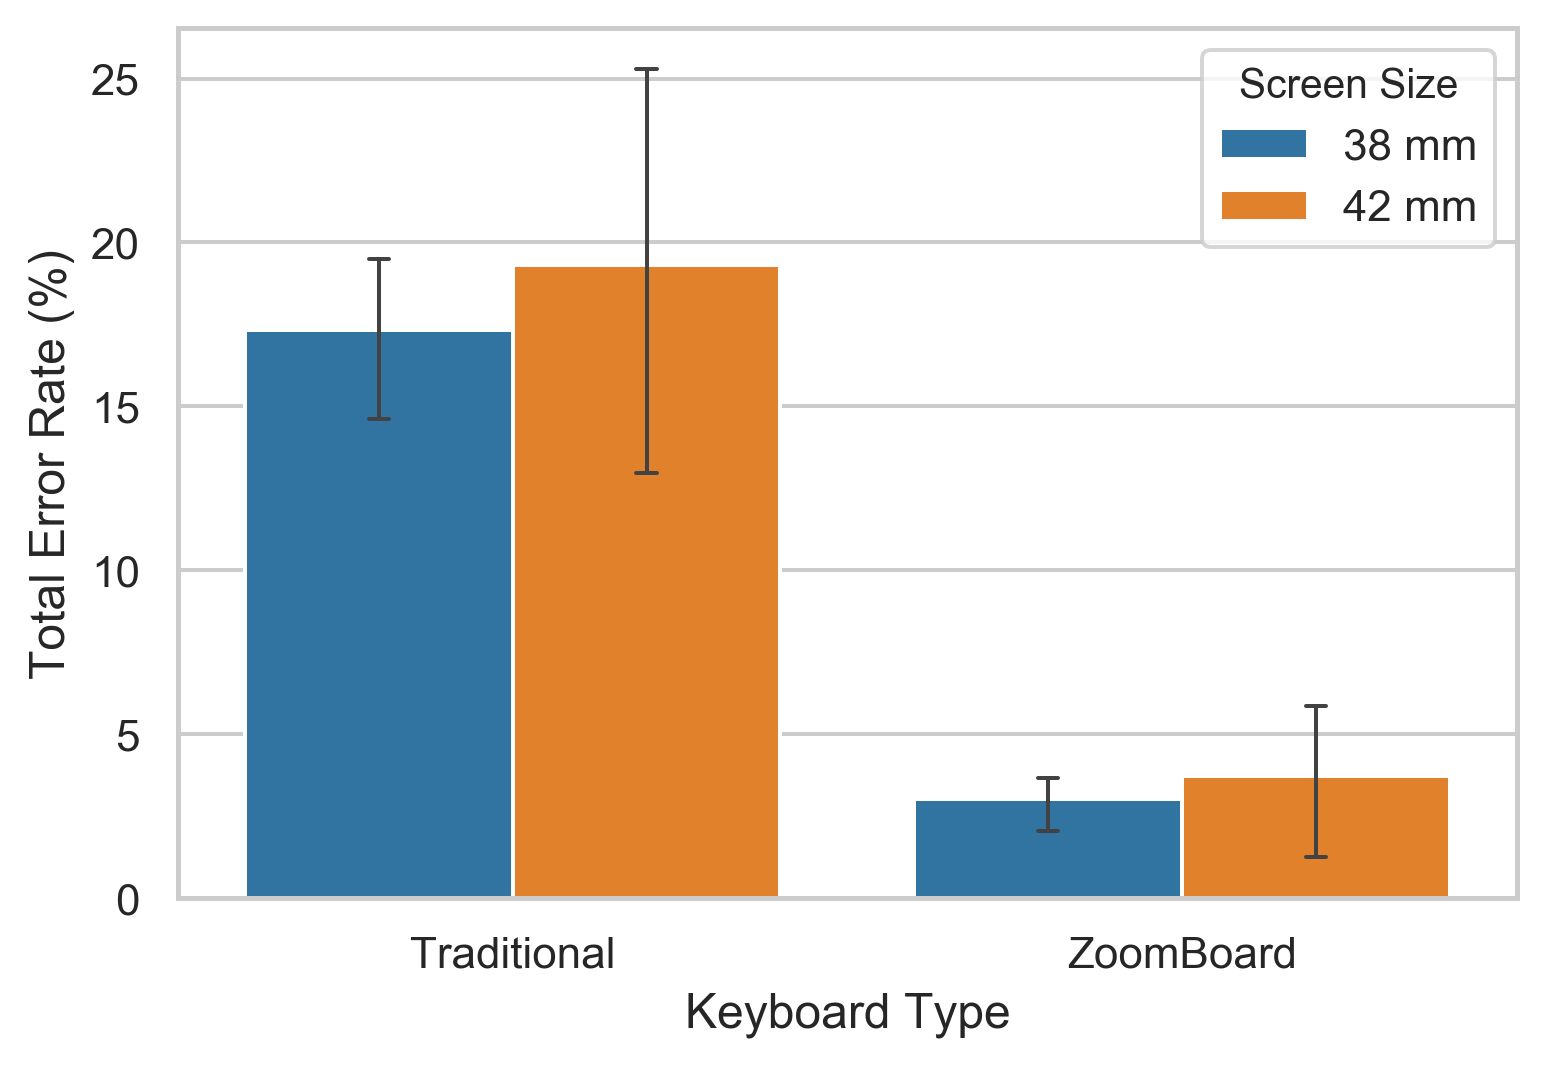

In [233]:
# Plotting Error Rate Graph
%matplotlib qt5
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
import matplotlib.pyplot as plt


sns.set_style("whitegrid")
sns.barplot(x='Keyboard Type', y='Total Error Rate (%)', hue='Screen Size', 
            data=df_piv, capsize=.03, errwidth=1)

plt.show()

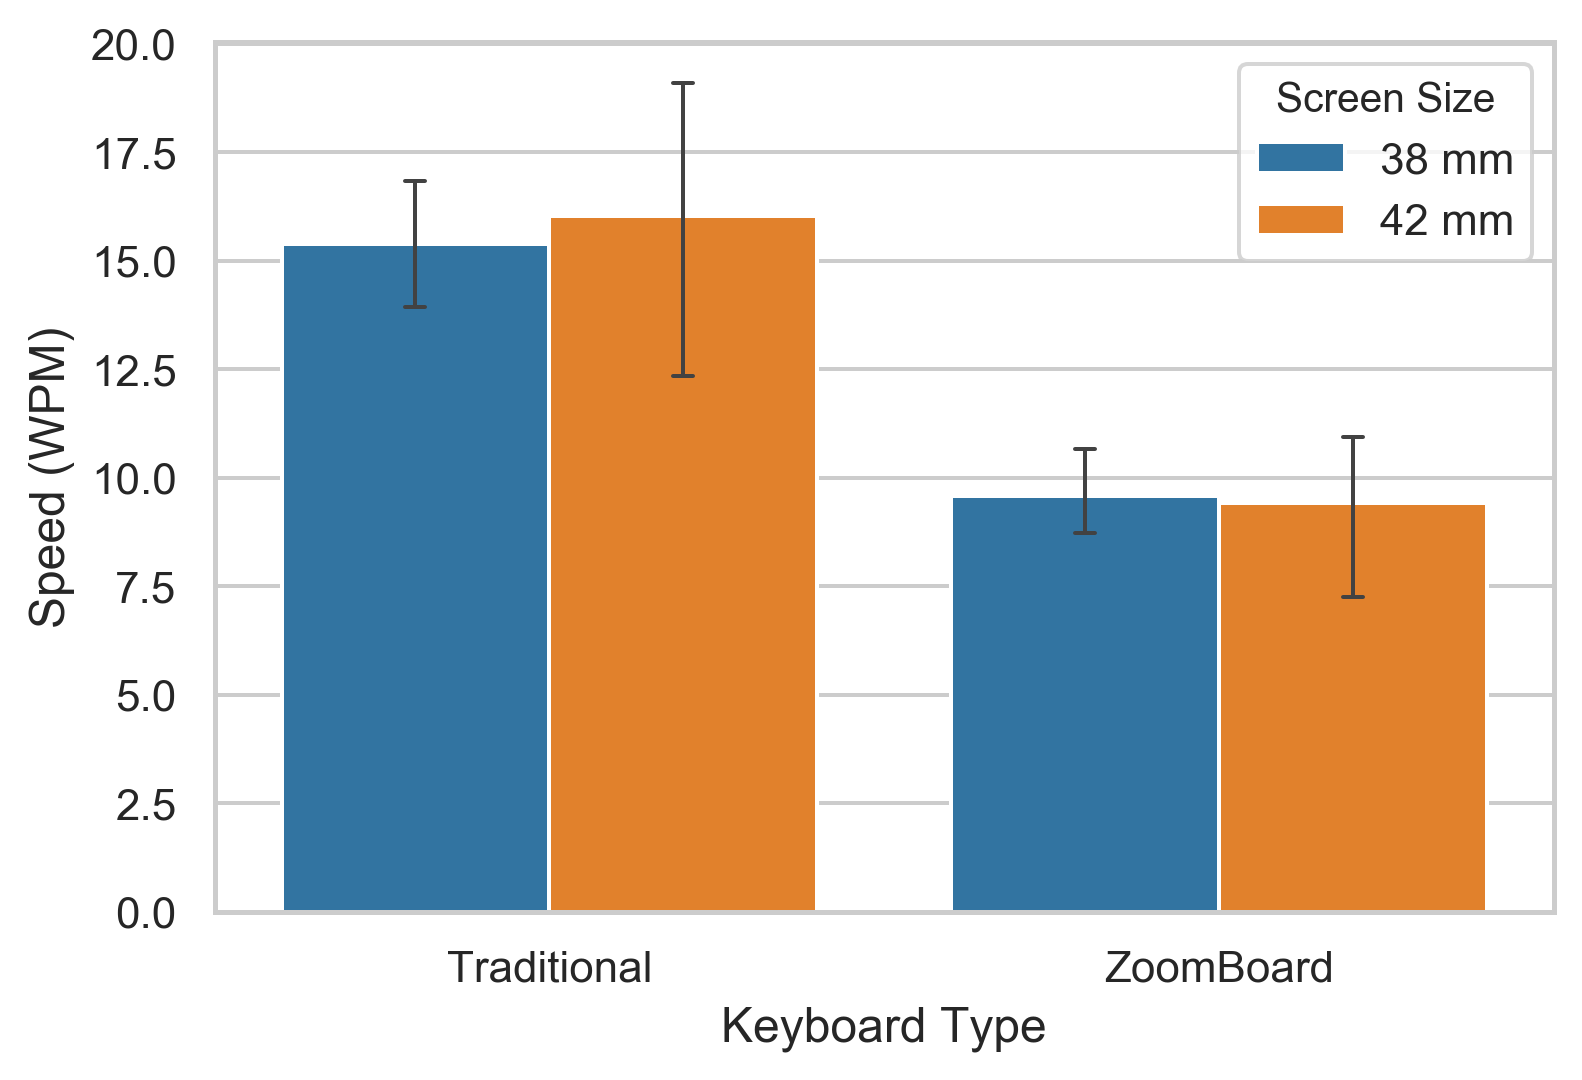

In [235]:
# Plotting Time Graph
sns.barplot(x='Keyboard Type', y='Speed (WPM)', hue='Screen Size', 
            data=df_piv, capsize=.03, errwidth=1)


In [239]:
import numpy as np
baselineSpeed = np.array([36.00, 43.00, 76.00, 48.33 ])
print(baselineSpeed.mean())
print(baselineSpeed.std())

50.832499999999996
15.174128269854581


In [240]:
import numpy as np
baselineError = np.array([3.67, 3.50, 1.67, 3.67])
print(baselineError.mean())
print(baselineError.std())

3.1275
0.8443451604646053


In [218]:
inputText = "your presentation was inspiring"

In [219]:
def getWords (inputText):
    words = inputText.split(" ")
    return len(words)

getWords (inputText)

4